In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from notebook_utils.utils import * 
from pycss.utils import *
from pycss.CSS import * 

In [2]:
standardize = True

T = pd.read_csv("../data/topic_exposure.csv").to_numpy()[:, 1:].astype(float)
D = pd.read_csv("../data/specific_variance.csv").to_numpy()[:, 1:].astype(float)
X = pd.read_csv("../data/factor_exposure.csv").to_numpy()[:, 1:].astype(float)
F = pd.read_csv("../data/factor_covariance.csv").to_numpy()[:, 1:].astype(float)

V = X @ F @ X.T + np.diag(np.squeeze(D))
Sigma = T.T @ V @ T

p = Sigma.shape[0]

if standardize:
    Sigma = standardize_cov(Sigma)

In [ ]:

p_max = 30
eigs = np.sort(np.linalg.eig(Sigma)[0])[::-1]

css_greedy_var_explained = np.zeros(p_max)
css = CSS()
css.select_subset_from_cov(Sigma, k=p_max, method='greedy')
for i in range(1, p_max + 1):
    css_greedy_var_explained[i - 1] =  1 - np.mean(np.diag(regress_off(Sigma, css.S[:i]))) 




css_swap_var_explained = np.zeros(p_max)
num_inits = 25
for i in tqdm(range(1, p_max + 1)):
    lowest = np.inf
    for _ in range(num_inits):
        try:
            css.select_subset_from_cov(Sigma, k=i, method='swap')
            val = np.mean(np.diag(css.Sigma_R))
            if val < lowest:
                lowest = val
        except:
            pass
    css_swap_var_explained[i - 1] = 1 - lowest 

  0%|          | 0/30 [00:00<?, ?it/s]

/Users/anavsood/mambaforge/envs/css/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


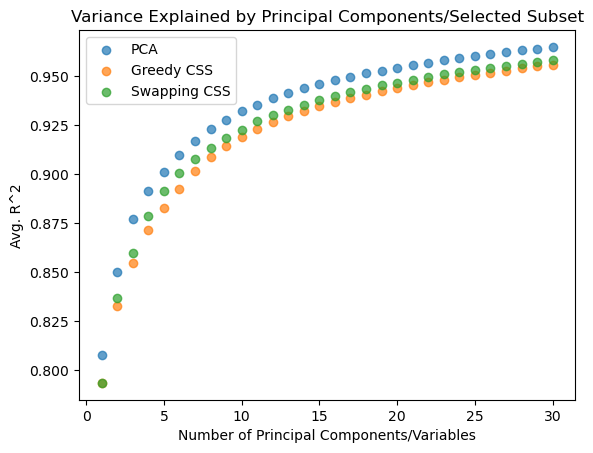

In [5]:
plt.scatter(np.arange(1, p_max + 1), [np.sum(eigs[:i])/np.sum(eigs) for i in range(1, p_max + 1)], label='PCA', alpha=0.7)
plt.scatter(np.arange(1, p_max + 1), css_greedy_var_explained, label='Greedy CSS', alpha=0.7)
plt.scatter(np.arange(1, p_max + 1), css_swap_var_explained, label='Swapping CSS', alpha=0.7)
plt.title("Variance Explained by Principal Components/Selected Subset")
plt.ylabel("Avg. R^2")
plt.xlabel("Number of Principal Components/Variables")
plt.savefig("../figures/blackrock_results.pdf")
plt.legend()

In [12]:
print(css_greedy_var_explained)
print(css_swap_var_explained)

[0.7934445  0.83252599 0.8546137  0.87148977 0.88269912 0.89250351
 0.90136511 0.90877926 0.91415754 0.9188751  0.92293612 0.92644305
 0.92968578 0.93218311 0.93458444 0.93680345 0.93877498 0.94052971
 0.94225815 0.94391974 0.94552264 0.94685809 0.94814606 0.94938765
 0.9505486  0.95165954 0.95276112 0.95380683 0.95482028 0.95580765]
[0.7934445  0.83667549 0.85977817 0.87841295 0.89154404 0.90048168
 0.90750973 0.9132941  0.91831734 0.92265138 0.92686026 0.93029303
 0.93286086 0.93538281 0.93780586 0.93975566 0.94162754 0.94343019
 0.94513622 0.94661481 0.94808736 0.94950522 0.95086619 0.95201086
 0.95313978 0.95420381 0.95523616 0.95630403 0.95725886 0.9581948 ]


Compare greedy runtime to naive

In [58]:
tol=1e-10
p_max = 30

css = CSS()
start = time.time()
css.select_subset_from_cov(Sigma, k=p_max, method='greedy')
end = time.time()
efficient_time = end - start

start = time.time()
S = []
for i in tqdm(range(p_max)):
    options = complement(p, S)
    best_val = np.inf
    best_j = np.nan
    for j in options:
        option_val = np.mean(np.diag(regress_off(Sigma, S + [j])))
        if option_val < best_val:
            best_val = option_val
            best_j = j
    S.append(best_j)
end = time.time()
naive_time = end - start

print(naive_time/efficient_time)

  0%|          | 0/30 [00:00<?, ?it/s]

3754.7352689169234


Compare swapping runtime to naive

In [3]:
p_max = 30

N = 100

start = time.time()
css = CSS()
css.select_subset_from_cov(Sigma, k=p_max, method='swap')
end = time.time()
whole_time = end - start 

start = time.time()
css.select_subset_from_cov(Sigma, k=p_max, method='swap', S_init=css.S)
end = time.time()
efficient_time = end - start

start = time.time()
S = css.S.copy()
for i in tqdm(range(len(S))):
    current_val = np.mean(np.diag(regress_off(Sigma, S)))
    options = np.delete(np.arange(p), S)
    best = np.inf 
    best_S_option = np.nan
    for j in options:
        S_option = S.copy()
        S_option[i] = j
        option_val = np.mean(np.diag(regress_off(Sigma, S_option)))
        if option_val < best:
            best = option_val
            best_S_option = S_option
    if best < current_val:
        S = best_S_option.copy()
    break
end = time.time()
naive_time = (end - start) * p_max

  0%|          | 0/30 [00:00<?, ?it/s]

In [56]:
print(whole_time)
print(naive_time/efficient_time)

0.6999239921569824
5180.495563750383


In [4]:
def swapping_subset_selection(Sigma, 
                              k,
                              objective,
                              max_iter=100,
                              S_init=None,
                              tol=TOL,
                              flag_colinearity=False):

    """
    Given a covariance `Sigma`, a subset size `k`, and an objective function `objective`
    returns the subset of variables `k` which minimize the objective selected by a gradient descent
    like iterative swapping algorithm. 

    Parameters
	----------
	Sigma : np.array
	    A `(p, p)`-shaped covariance matrix. 
    k : int
        Size of subset to search for.
    objective : Callable[np.array, bool, np.float]
        A python function which defines the objective. On each iteration the variable which 
        minimizes objective will be selected.
    max_iter : int, default=`100`
        Maximum number of iterations to run the swapping algorithm. If algorithm has not 
        converged within `max_iter` iterations, the algorithm will terminate and provide 
        results in its current state. In this case `converged` will be `False.
    S_init : np.array, default=`None`
        Intial subset to start the algorithm with. If not included, an initial subset is 
        selected uniformly randomly.  
    tol : float, default=`TOL`
        Tolerance at which point we consider a variable to have zero variance.
    flag_colinearity : bool, default=`True`
        Whether or not to flag colinearity issues and terminate upon their happening. 
	
    Returns 
	-------
	S : np.array
        The selected subset, in order it was selected.
    Sigma_R : np.array
        The `(p, p)`-shaped residual covariance matrix resulting from regressing the selected subset
        out of all the varibles (including themselves). 
    S_init : np.array
        The inital subset that the algorithm starts with.
    converged : bool
        Whether the algorithm has converged. If `converged` is `False` and the `errors` list is non-empty 
        then `S` and `Sigma_R` must be `None`. 
    errors : List[ValueError]
         List of ValueError objects detailing what the colinearity issues are. 
	"""

    converged = False
    p = Sigma.shape[0]
    d = p-k
    idx_order = np.arange(p)
    
    if S_init is None:
        S_init = np.random.choice(idx_order, k, replace=False)
    elif len(S_init) != k:
        raise ValueError("Initial subset must be of length k.")
    
    Sigma_R = Sigma.copy()
    # these will always be the indices of the selected subset
    subset_idxs = np.arange(d, p)
    # swap initial variables to bottom of Sigma 
    swap_in_place(Sigma_R, subset_idxs, S_init, idx_order=idx_order)
    S = idx_order[d:].copy()
    Sigma_S = Sigma[:, S][S, :].copy()
    invertible, Sigma_S_L = is_invertible(Sigma_S) 
    
    if not invertible:
        return None, None, S_init, converged, populate_colinearity_errors(S)
    
    regress_off_in_place(Sigma_R, np.arange(d, p))
    zero_idxs = np.where(np.diag(Sigma_R)[:d] <= tol)[0]
    num_zero_idxs = len(zero_idxs)
    
    if flag_colinearity and num_zero_idxs > 0:
        return None, None, S_init, converged, populate_colinearity_errors(S, responses=idx_order[zero_idxs])

    # number of completed iterations
    N = 0
    # counter of how many consecutive times a selected variable was not swapped
    not_replaced = 0
    # permutation which shifts the last variable in the subset to the top of the subset
    subset_idxs_permuted = np.concatenate([subset_idxs[1:], np.array([subset_idxs[0]])])
    break_flag = False 

    while N < max_iter and (not break_flag):
        for i in range(k):
            S_0 = S[0]
            # Remove first variable from selected subset 
            T = S[1:]

            # Update cholesky after removing first variable from subset 
            Sigma_T_L = update_cholesky_after_removing_first(Sigma_S_L) 

            # Update residual covariance after removing first variable from subset
            v = Sigma[:, S_0] - Sigma[:, T] @ solve_with_cholesky(Sigma_T_L, Sigma[T, S_0]) if k > 1 else Sigma[:, S_0]
            reordered_v = v[idx_order]
            Sigma_R = Sigma_R + np.outer(reordered_v, reordered_v)/v[S_0]

            # Swap first variable from subset to to top of residual matrix 
            swap_in_place(Sigma_R, np.array([0]), np.array([d]), idx_order=idx_order)  
        
            # If not flag_colinearity, find indices of variables with zero variance
            if not flag_colinearity:
                zero_idxs = np.where(np.diag(Sigma_R)[:(d + 1)] <= tol)[0]
                num_zero_idxs = len(zero_idxs)
                # In residual matrix, swap variables with zero indices to right above currently selected subset (of size k-1)
                swap_in_place(Sigma_R, zero_idxs, np.arange(d + 1 - num_zero_idxs, d + 1), idx_order=idx_order)
            else:
                num_zero_idxs = 0
        
            # update num_active
            num_active = d + 1 - num_zero_idxs 

            # compute objectives and for active variables and find minimizers
            obj_vals, colinearity_error_idxs = objective(Sigma_R[:num_active, :num_active], flag_colinearity=flag_colinearity, tol=tol)

            if len(colinearity_error_idxs[0]) > 0:
                return None, None, S_init, converged, populate_colinearity_errors(S[:i], 
                                                                                  idx_order[colinearity_error_idxs[0]], 
                                                                                  idx_order[colinearity_error_idxs[1]])
        
            choices = np.flatnonzero(obj_vals == obj_vals.min())

            # if removed variable is a choice, select it, otherwise select a random choice
            if 0 in choices:
                not_replaced += 1
                j_star = 0 
            else:
                not_replaced = 0
                j_star = np.random.choice(choices)

            # Add new choice as the last variable in selected subset
            S_new = idx_order[j_star]
            S[:k-1] = S[1:]
            S[k-1] = S_new
            # Update cholesky after adding new choice as last variable in selected subset 
            Sigma_S_L = update_cholesky_after_adding_last(Sigma_T_L, Sigma[S_new, S])
            # In residual covariance, regress selected variable off the remaining
            #regress_one_off_in_place(Sigma_R[:(d+1), :(d+1)], j_star) #alternative option
            regress_one_off_in_place(Sigma_R[:num_active, :num_active], j_star)
            # In residual covariance swap new choice to top of selected subset and then permute selected subset
            # so the new choice is at the bottom, reflecting S
            swap_in_place(Sigma_R, np.array([j_star]), np.array([d]), idx_order=idx_order)
            perm_in_place(Sigma_R, subset_idxs,  subset_idxs_permuted, idx_order=idx_order)
        
            if not_replaced == k:
                converged=True
                break_flag=True
                break

        N += 1

    perm_in_place(Sigma_R, np.arange(p), np.argsort(idx_order))
    return N-1, S, Sigma_R, S_init, converged, []

In [5]:
B = 100
iters = []
for i in tqdm(range(B)):
    N, _, _, _, _, _ = swapping_subset_selection(Sigma, p_max, css_objective)
    iters.append(N)

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 6, got 5)

(array([ 4.,  0., 45.,  0.,  0., 29.,  0., 16.,  0.,  5.]),
 array([2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8, 5.2, 5.6, 6. ]),
 <BarContainer object of 10 artists>)

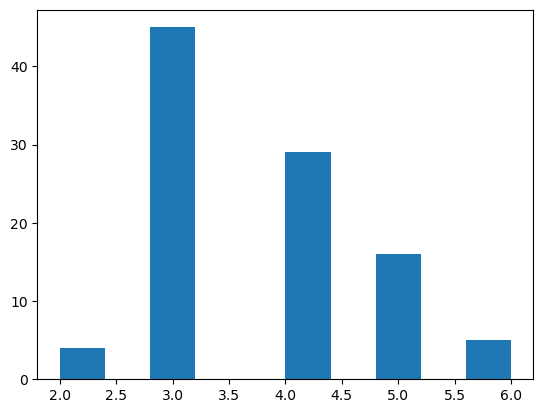

In [6]:
plt.hist(iters)

In [7]:
print(naive_time * np.median(iters))
print(naive_time * np.mean(iters))

2750.4223251342773
2562.893530238758
